# Wellbeing Police

From various subreddit, we have scraped close to 4000 posts. The subreddits include "r/SuicideWatch", "r/BipolarReddit", "r/Anxiety", "r/AnxietyDepression", "r/Depression", and "r/Happy". Each of the subreddit posts currently sitting within its own csv file. We will see what are the fields that are consistent across the CSV files and choose those applicable. Clean up the data, removed the columns not needed. 

As all the scrapes was created from the same script, the columns of the resulting csv are same across the files. 
We will proceed to label them according to the subreddit they came from and combine them into a single dataframe.

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import numpy as np
import pandas as pd
import glob
import os
import spacy
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

from src.utils import color_func, get_mask, search,text_normalization

### Data Combination and Labeling

We retrieved posts in “Hot” section from various subreddits:
`r/ptsd`,`r/Anxiety`,`r/SuicideWatch`,`r/depression`,`r/BipolarReddit`,`r/schizophrenia`,`r/EDAnonymous`,`r/EatingDisorders`

In [23]:
path = "./reddit/csvs/"
all_csvs = glob.glob(os.path.join(path, "*.csv"))

all_dfs = []
for filename in all_csvs:
    df = pd.read_csv(filename, index_col=None, header=0)
    df = df[["title", "subreddit", "body"]]
    
    # ## manually remove irrelevant pinned posts
    # if df.iloc[0].subreddit in ["ptsd",'Anxiety',"SuicideWatch",'EDAnonymous']: 
    #     df=df[2:]
    # if df.iloc[0].subreddit in ['BipolarReddit','schizophrenia','EatingDisorders']:
    #     df=df[1:]
        
    all_dfs.append(df)

main_df = pd.concat(all_dfs)
print(main_df.shape)
main_df = main_df.drop_duplicates()
print(main_df.shape)
main_df.head()


(34857, 3)
(23741, 3)


,title,subreddit,body
0,Text Tuesday- share your stories that made you...,MadeMeSmile,Welcome to Text Tuesdays! This is the place to...
1,r/mademesmile has a discord server!,MadeMeSmile,NaN
2,Don’t let others tell you what to do.,MadeMeSmile,NaN
3,Pedro pascal bought five guys for all of the l...,MadeMeSmile,NaN
4,A gorgeous dinner in Rome on our Honeymoon!!! ...,MadeMeSmile,NaN


A few of the subreddit is indicating the same underlying mental problems, we proceed to add an attribute such that these minor differentiation will be grouped for better and easier identification.

In [24]:
sub_problem_mapping = {
    "ptsd": "PTSD",
    "CPTSD": "PTSD",
    "Anxiety": "anxiety",
    "Anxietyhelp": "anxiety",
    "SuicideWatch": "suicidal",
    "selfharm": "suicidal",
    "depression": "depression",
    "depression_help": "depression", 
    "BipolarReddit": "bipolar", 
    "bipolar": "bipolar",
    "schizophrenia": "schizophrenia",
    "EDAnonymous": "eating disorder",
    "EatingDisorders": "eating disorder",
    "happy": "control",
    "MadeMeSmile": "control"
}

main_df["problem"] = [sub_problem_mapping[s] for s in main_df["subreddit"]]
main_df.head()


,title,subreddit,body,problem
0,Text Tuesday- share your stories that made you...,MadeMeSmile,Welcome to Text Tuesdays! This is the place to...,control
1,r/mademesmile has a discord server!,MadeMeSmile,NaN,control
2,Don’t let others tell you what to do.,MadeMeSmile,NaN,control
3,Pedro pascal bought five guys for all of the l...,MadeMeSmile,NaN,control
4,A gorgeous dinner in Rome on our Honeymoon!!! ...,MadeMeSmile,NaN,control


### Text Cleaning and Processing
- Remove emoticons and non-text characters
- Remove excess newline and spacing characters added for emphasis (e.g., poetry paragraphing)
- Remove hyperlinks and tags
- Change text to lowercase
- Simplify punctuation by removing repeated characters (e.g., "?????", "!!!!")

In [25]:
from text_processing import text_processing

In [26]:

clean_text = text_processing()

clean_text.process_data(main_df, headers = ['title', 'subreddit', 'body'])

main_df.head()

,title,subreddit,body,problem
0,text tuesday- share your stories that made you...,mademesmile,welcome to text tuesdays! this is the place to...,control
18,i'm finally going to see my grandpa again afte...,mademesmile,i know it's not much but i love this man despi...,control
33,mr. pickles is a 1st time dad @ 90y he is a cr...,mademesmile,mr. pickles has lived at the houston zoo since...,control
48,wholesome story of an elderly lady at a meshug...,mademesmile,"for context, she was in the front row of meshu...",control
50,raccoon family in my back yard,mademesmile,"so, last year i discovered i had a family of r...",control


### Apply further text normalization steps, tokenization and  lemmatization using spaCy

We scrap common text abbreviations into a dictionary from below link and also manually added in some common abbreviate words. https://www.slicktext.com/blog/2019/02/text-abbreviations-guide/

We use spaCy to perform tokenization and lemmatization.

In [27]:
# # Group the data by class label
# groups = main_df.groupby('problem')

# # Sample 2 rows from each group
# sampled_data = groups.apply(lambda x: x.sample(n=100)).reset_index(drop=True)

## Apply further cleaning steps before tokenization
normalized_text = text_normalization()

normalized_text.normalize_data(main_df)

,title,subreddit,body,problem
0,text tuesday- share your stories that made you...,mademesmile,welcome to text tuesdays! this is the place to...,control
18,i'm finally going to see my grandpa again afte...,mademesmile,i know it's not much but i love this man despi...,control
33,mr. pickles is a 1st time dad @ 90y he is a cr...,mademesmile,mr. pickles has lived at the houston zoo since...,control
48,wholesome story of an elderly lady at a meshug...,mademesmile,"for context, she was in the front row of meshu...",control
50,raccoon family in my back yard,mademesmile,"so, last year i discovered i had a family of r...",control
...,...,...,...,...
75,need advice,eatingdisorders,"(trigger warning low calories , mention of puk...",eating disorder
101,recovery is so weird,eatingdisorders,i’ve struggled with my eating habits for as lo...,eating disorder
107,im more scared to eat than usual today,eatingdisorders,i promised myself i wouldnt feel guilty for ea...,eating disorder
131,should i be worried about my sister,eatingdisorders,i have struggled with anorexia in the past and...,eating disorder


In [28]:
nlp = spacy.load('en_core_web_sm')
    
def lemmatize(text):
    doc = nlp(text)
    
    # Turn it into tokens, ignoring the punctuation
    tokens = [token for token in doc if not token.is_punct]
    
    # ignoring the stopwords
    tokens = [ token for token in tokens if not token.is_stop]
     
    # Convert those tokens into lemmas, EXCEPT the pronouns
    lemmas = [token.lemma_ if token.pos_ != 'PRON' else token.orth_ for token in tokens]
    return lemmas

In [29]:
# ## Directly apply lemmatize function to documents to get tokenized text
# # document_lemmatized = [lemmatize(post) for post in documents]
# # document_lemmatized  

### Create Document-Term Matrices using TF-IDF Weights with N-grams

- restrict the vocabulary to some maximum size to 15000
- set range of n-gram sizes from 1 to 3

In [30]:
### Create TF-IDF vector for all documents for traning t
documents = main_df.body

tfidf_vectorizer = TfidfVectorizer(tokenizer=lemmatize, norm='l1',ngram_range=(1, 3),max_features=15000)
text_tfidf = tfidf_vectorizer.fit_transform(documents)
text_tfidf = np.asarray(text_tfidf.todense())

tokens = tfidf_vectorizer.get_feature_names_out()

### Visualize text using work cloud and TF-IDF

We convert documents with same problem into each TF-IDF vector and visulize the vector to see top 500 words in high TF-IDF weights for each problem.

Word cloud of posts from problem control


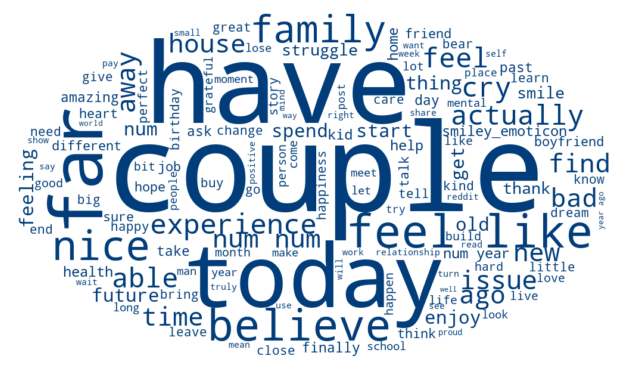

Word cloud of posts from problem eating disorder


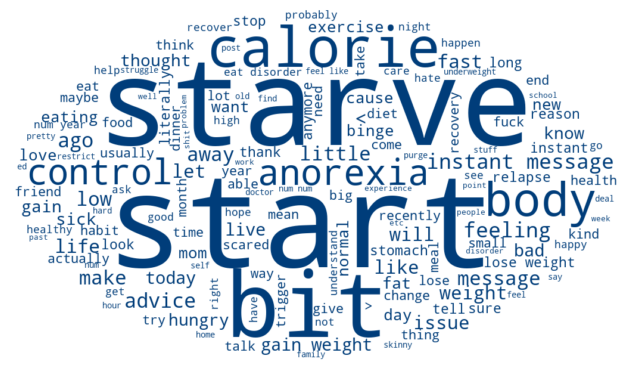

Word cloud of posts from problem depression


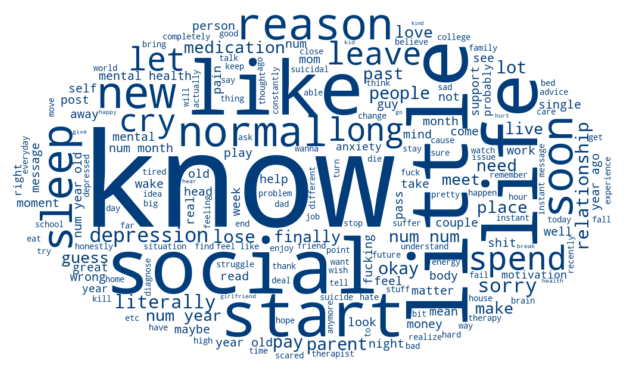

Word cloud of posts from problem PTSD


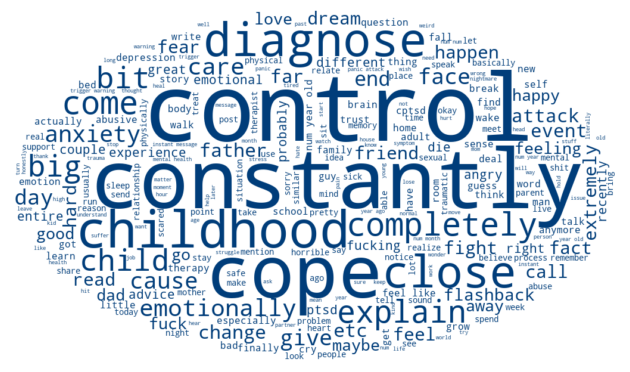

Word cloud of posts from problem bipolar


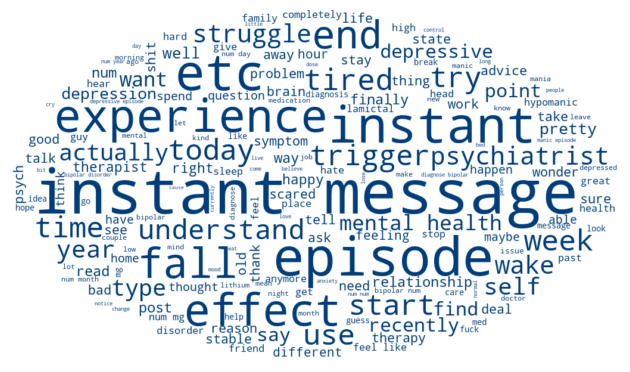

Word cloud of posts from problem suicidal


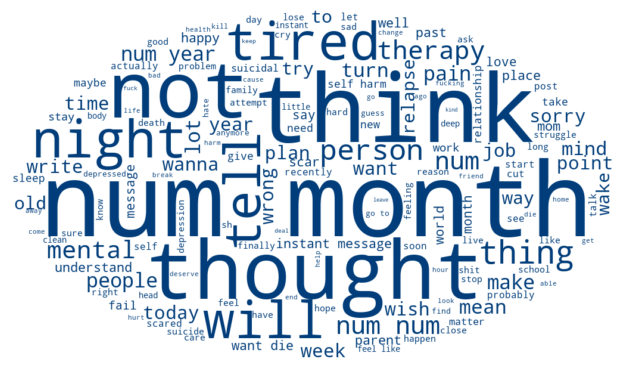

Word cloud of posts from problem schizophrenia


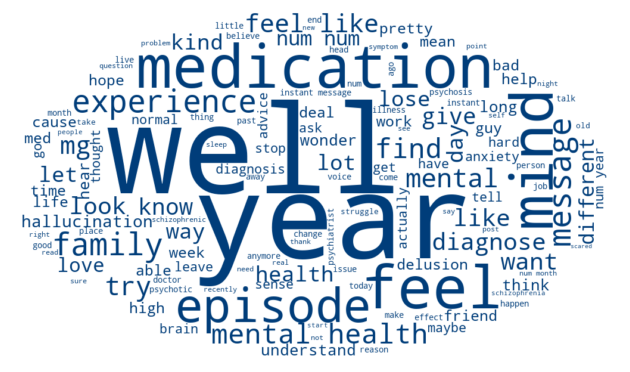

Word cloud of posts from problem anxiety


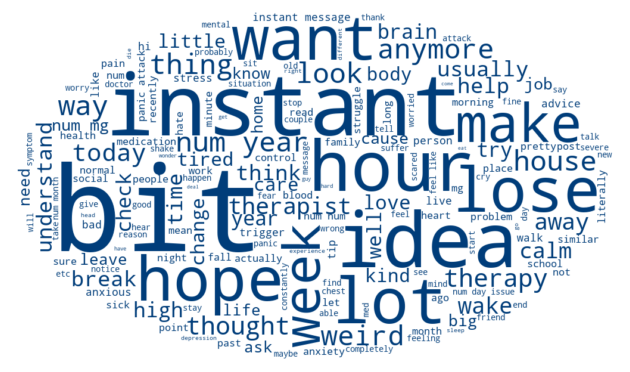

In [31]:
for syp in main_df.problem.unique():
    df_problem = main_df[main_df['problem'] == syp]
    
    problem_documents=df_problem.body
    
# for syp in sampled_data.problem.unique():

#     problem_documents = sampled_data[sampled_data['problem'] == syp]['body']
    
    print(f"Word cloud of posts from problem {syp}")
    
    problem_tfidf_vectorizer = TfidfVectorizer(tokenizer=lemmatize, norm='l1',ngram_range=(1, 3),min_df=0.05)
    
    problem_text_tfidf = problem_tfidf_vectorizer.fit_transform(problem_documents)
    problem_text_tfidf= np.asarray(problem_text_tfidf.todense())
    tokens = problem_tfidf_vectorizer.get_feature_names_out()
    
    
    problem_weights = list(problem_text_tfidf[np.nonzero(problem_text_tfidf)])
    problem_word_freqs = { w:problem_weights[idx]  for (idx, w) in enumerate(tokens) }

    wc = WordCloud(color_func=color_func, 
                   background_color="white", 
                   mask=get_mask(),
                   max_words=500,
                   contour_width=0)

    wc.generate_from_frequencies(problem_word_freqs)

    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

### KNN-Classification

#### Create Training & Test Set

With the method `train_test_split()`, set the size of the test set to 20%.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline

from tqdm import tqdm

#### KNN simple (Ngram = 1 , K = 7)

In [33]:
sentences = main_df.body
labels = main_df.problem
num_labels = len(labels.unique()) ##should be 7
print("Size of label/class : {}".format(num_labels))

# Split sentences and labels into training and test set with a test set size of 20%
sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# We can directly convert the numerical class labels from lists to numpy arrays
y_train = np.asarray(labels_train)
y_test = np.asarray(labels_test)

print("Size of training set: {}".format(len(sentences_train)))
print("Size of test set: {}".format(len(sentences_test)))

Size of label/class : 8
Size of training set: 16944
Size of test set: 4236


In [34]:
#Commented (use jenny tfidf above)
#tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=20000)

X_train = tfidf_vectorizer.fit_transform(sentences_train)
X_test = tfidf_vectorizer.transform(sentences_test)

#save pickles for subsequent use to speed up processing
import pickle
pickle.dump(X_train, open("processing/X_train.pickle","wb"))
pickle.dump(X_test, open("processing/X_test.pickle","wb"))

# #load pickles instead of tfidf_vectorizer
# X_train = pickle.load(open("processing/X_train.pickle","rb"))
# X_test = pickle.load(open("processing/X_test.pickle","rb"))

In [35]:
knn = KNeighborsClassifier(n_neighbors=num_labels, n_jobs=-1).fit(X_train, y_train)

In [36]:
#Prediction 
y_pred = knn.predict(X_test)
precision = metrics.precision_score(y_test, y_pred, average='micro')
recall = metrics.recall_score(y_test, y_pred, average='micro')
f1 = metrics.f1_score(y_test, y_pred, average='micro')

print("Precison: {:.3f}".format(precision))
print("Recall:   {:.3f}".format(recall))
print("F1 score: {:.3f}".format(f1))
print(metrics.classification_report(y_test, y_pred))

Precison: 0.191
Recall:   0.191
F1 score: 0.191
                 precision    recall  f1-score   support

           PTSD       0.22      0.05      0.08       584
        anxiety       0.51      0.09      0.15       644
        bipolar       0.35      0.04      0.07       500
        control       0.01      0.02      0.01        50
     depression       0.20      0.35      0.25       727
eating disorder       0.31      0.21      0.25       668
  schizophrenia       0.09      0.31      0.13       278
       suicidal       0.21      0.28      0.24       785

       accuracy                           0.19      4236
      macro avg       0.23      0.17      0.15      4236
   weighted avg       0.27      0.19      0.18      4236



#### KNN with Iteration to find best N-gram (1-3)

In [37]:
k_sizes = [7]
#k_sizes = [7, 17, 27]

max_ngram_size = 3
num_k = len(k_sizes)

# Number runs = number traing/test a KNN classifier
num_runs = max_ngram_size * num_k

# numpy array to keep track of all results
knn_results = np.zeros((max_ngram_size, num_k))

with tqdm(total=num_runs) as pbar:
    for i, ngram in enumerate(range(1, max_ngram_size+1)):
        # Create Document-Term Matrix for different n-gram sizes
        #tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, ngram), max_features=20000)
        tfidf_vectorizer = TfidfVectorizer(tokenizer=lemmatize, norm='l1',ngram_range=(1, ngram),max_features=15000)
        X_train = tfidf_vectorizer.fit_transform(sentences_train)
        X_test = tfidf_vectorizer.transform(sentences_test)
        # Train & test model using cross validation
        for j, k in enumerate(k_sizes):
            knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
            scores = cross_val_score(knn, X_train, y_train, cv=10, scoring="f1_micro")
            mean_score = np.mean(scores)
            knn_results[i,j] = mean_score
            pbar.update(1)

100%|██████████| 3/3 [21:57<00:00, 439.22s/it]


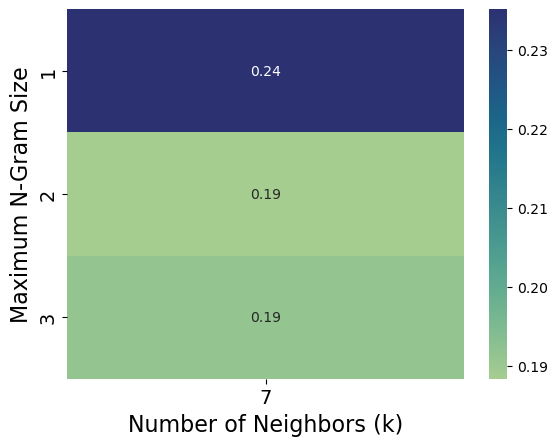

In [38]:
# Use the heatmap function from the seaborn package
plt.figure()

sns.heatmap(knn_results, annot=True, cmap="crest", xticklabels=k_sizes, yticklabels=list(range(1,max_ngram_size+1)))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Maximum N-Gram Size', fontsize=16)
plt.xlabel('Number of Neighbors (k)', fontsize=16)

plt.show()

#### Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(cv=10, random_state=42, n_jobs=-1)

model.fit(X_train, y_train)

model.predict(X_test)

model.score(X_test,y_test)


/home/david/anaconda3/envs/cs5246/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/david/anaconda3/envs/cs5246/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

0.6900377714825306

In [40]:
precision = metrics.precision_score(y_test, y_pred, average='micro')
recall = metrics.recall_score(y_test, y_pred, average='micro')
f1 = metrics.f1_score(y_test, y_pred, average='micro')

print("Precison: {:.3f}".format(precision))
print("Recall:   {:.3f}".format(recall))
print("F1 score: {:.3f}".format(f1))
print(metrics.classification_report(y_test, y_pred))

Precison: 0.191
Recall:   0.191
F1 score: 0.191
                 precision    recall  f1-score   support

           PTSD       0.22      0.05      0.08       584
        anxiety       0.51      0.09      0.15       644
        bipolar       0.35      0.04      0.07       500
        control       0.01      0.02      0.01        50
     depression       0.20      0.35      0.25       727
eating disorder       0.31      0.21      0.25       668
  schizophrenia       0.09      0.31      0.13       278
       suicidal       0.21      0.28      0.24       785

       accuracy                           0.19      4236
      macro avg       0.23      0.17      0.15      4236
   weighted avg       0.27      0.19      0.18      4236

